<a href="https://colab.research.google.com/github/Ermi1223/SSM-Time-Series-Prediction/blob/main/SSM_Time_Series_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Step 1: Install Libraries & Import Dependencies**

In [ ]:
!pip install numpy pandas torch matplotlib

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 98.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 71.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 39.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 6.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 81.5 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitlin

In [1]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error

**Step 2: Load and Preprocess Data**

**2.1 Load Sample Data (Daily Temperature Dataset)**

In [4]:
# Example: Load a temperature dataset from a URL
url = "https://raw.githubusercontent.com/jbrownlee/Datasets/master/daily-min-temperatures.csv"
data = pd.read_csv(url, parse_dates=['Date'], index_col='Date')
print(data.head())

            Temp
Date            
1981-01-01  20.7
1981-01-02  17.9
1981-01-03  18.8
1981-01-04  14.6
1981-01-05  15.8


**2.2 Handle Missing Values & Normalize**

In [5]:
# Fill missing values (if any)
data = data.ffill().bfill()

# Normalize to [0, 1]
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(data.values).flatten()

**2.3 Split into Sequences**

In [6]:
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data)-seq_length):
        X.append(data[i:i+seq_length])
        y.append(data[i+seq_length])
    return np.array(X), np.array(y)

seq_length = 30  # Use 30 days to predict the next day
X, y = create_sequences(scaled_data, seq_length)

# Split into train/test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

**2.4 Convert to PyTorch Tensors**

In [7]:
X_train = torch.FloatTensor(X_train).unsqueeze(-1)  # Shape: (samples, seq_len, 1)
y_train = torch.FloatTensor(y_train).unsqueeze(-1)
X_test = torch.FloatTensor(X_test).unsqueeze(-1)
y_test = torch.FloatTensor(y_test).unsqueeze(-1)

**Step 3: Define SSM Model and LSTM (PyTorch)**

In [8]:
# Define SSM model
class SSM(nn.Module):
    def __init__(self, state_dim=4, input_dim=1, output_dim=1):
        super(SSM, self).__init__()
        self.A = nn.Parameter(torch.randn(state_dim, state_dim) * 0.01)
        self.B = nn.Parameter(torch.randn(state_dim, input_dim) * 0.01)
        self.C = nn.Parameter(torch.randn(output_dim, state_dim) * 0.01)
        self.D = nn.Parameter(torch.randn(output_dim, input_dim) * 0.01)

    def forward(self, u_seq):
        batch_size, seq_len, _ = u_seq.shape
        x = torch.zeros(batch_size, self.A.shape[0]).to(u_seq.device)
        outputs = []
        for t in range(seq_len):
            u_t = u_seq[:, t, :]
            x = torch.matmul(x, self.A) + torch.matmul(u_t, self.B.T)
            y_t = torch.matmul(x, self.C.T) + torch.matmul(u_t, self.D.T)
            outputs.append(y_t)
        return torch.stack(outputs, dim=1)

# Define LSTM model
class LSTM(nn.Module):
    def __init__(self, input_dim=1, hidden_dim=64, output_dim=1):
        super(LSTM, self).__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, batch_first=True)
        self.linear = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        out, _ = self.lstm(x)
        return self.linear(out[:, -1, :])  # Predict last step

**Step 4: Train the SSM and LSTM**

In [9]:
# Training function
def train_model(model, X_train, y_train, epochs=50, lr=0.001, batch_size=32, model_name="model"):
    model.to(device)
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)
    train_losses = []

    for epoch in range(epochs):
        model.train()
        epoch_loss = 0.0
        for i in range(0, len(X_train), batch_size):
            batch_X = X_train[i:i + batch_size]
            batch_y = y_train[i:i + batch_size]

            optimizer.zero_grad()
            outputs = model(batch_X)
            if isinstance(model, SSM):
                loss = criterion(outputs[:, -1, :], batch_y)
            else:
                loss = criterion(outputs, batch_y)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()

        avg_loss = epoch_loss / (len(X_train) / batch_size)
        train_losses.append(avg_loss)
        print(f"[{model_name}] Epoch {epoch + 1}/{epochs}, Loss: {avg_loss:.4f}")

    # Save model
    torch.save(model.state_dict(), f"{model_name}_weights.pth")
    return train_losses

**Step 5: Evaluate SSM and LSTM**

In [10]:
# Initialize models
ssm_model = SSM()
lstm_model = LSTM()

# Train models
ssm_losses = train_model(ssm_model, X_train, y_train, model_name="SSM")
lstm_losses = train_model(lstm_model, X_train, y_train, model_name="LSTM")

# Load models (optional, for demonstration)
ssm_model.load_state_dict(torch.load("SSM_weights.pth"))
lstm_model.load_state_dict(torch.load("LSTM_weights.pth"))
ssm_model.eval()
lstm_model.eval()

# Evaluate models
with torch.no_grad():
    ssm_pred = ssm_model(X_test).cpu().numpy()[:, -1, :]
    lstm_pred = lstm_model(X_test).cpu().numpy()
    y_test_actual = y_test.cpu().numpy()

[SSM] Epoch 1/50, Loss: 0.1744
[SSM] Epoch 2/50, Loss: 0.0493
[SSM] Epoch 3/50, Loss: 0.0099
[SSM] Epoch 4/50, Loss: 0.0099
[SSM] Epoch 5/50, Loss: 0.0099
[SSM] Epoch 6/50, Loss: 0.0099
[SSM] Epoch 7/50, Loss: 0.0099
[SSM] Epoch 8/50, Loss: 0.0099
[SSM] Epoch 9/50, Loss: 0.0098
[SSM] Epoch 10/50, Loss: 0.0098
[SSM] Epoch 11/50, Loss: 0.0098
[SSM] Epoch 12/50, Loss: 0.0098
[SSM] Epoch 13/50, Loss: 0.0098
[SSM] Epoch 14/50, Loss: 0.0098
[SSM] Epoch 15/50, Loss: 0.0097
[SSM] Epoch 16/50, Loss: 0.0097
[SSM] Epoch 17/50, Loss: 0.0097
[SSM] Epoch 18/50, Loss: 0.0097
[SSM] Epoch 19/50, Loss: 0.0097
[SSM] Epoch 20/50, Loss: 0.0097
[SSM] Epoch 21/50, Loss: 0.0096
[SSM] Epoch 22/50, Loss: 0.0096
[SSM] Epoch 23/50, Loss: 0.0096
[SSM] Epoch 24/50, Loss: 0.0096
[SSM] Epoch 25/50, Loss: 0.0096
[SSM] Epoch 26/50, Loss: 0.0095
[SSM] Epoch 27/50, Loss: 0.0095
[SSM] Epoch 28/50, Loss: 0.0095
[SSM] Epoch 29/50, Loss: 0.0095
[SSM] Epoch 30/50, Loss: 0.0095
[SSM] Epoch 31/50, Loss: 0.0095
[SSM] Epoch 32/50

**Step 6: Evaluate and Compare**

SSM - RMSE: 2.2535, MAE: 1.7665
LSTM - RMSE: 2.1883, MAE: 1.7267


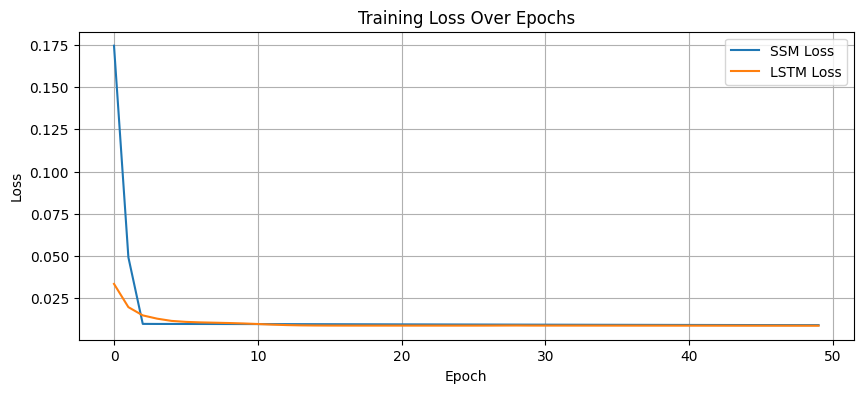

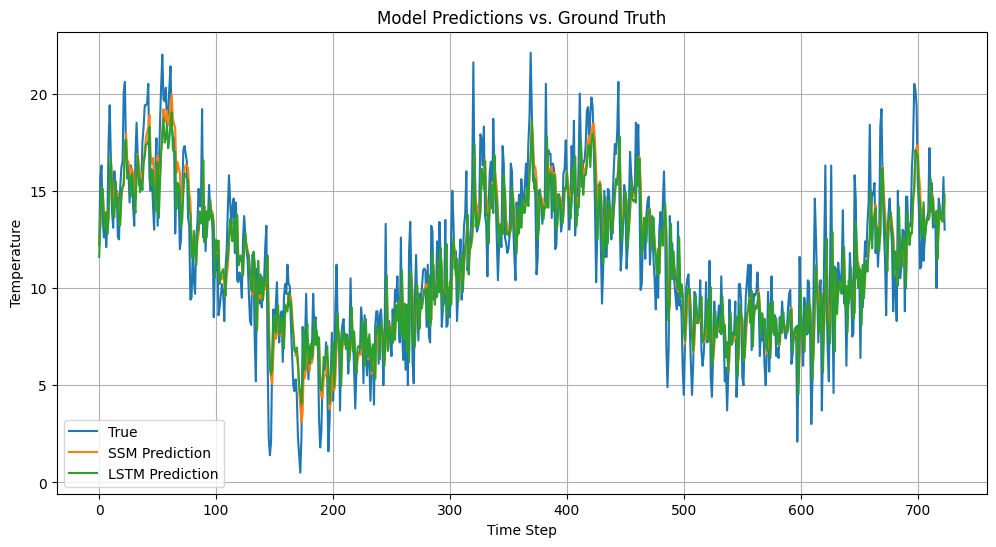

In [12]:
# Inverse transform predictions
ssm_pred_inv = scaler.inverse_transform(ssm_pred)
lstm_pred_inv = scaler.inverse_transform(lstm_pred)
y_test_inv = scaler.inverse_transform(y_test_actual)

# Compute metrics
def compute_metrics(y_true, y_pred, model_name):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    print(f"{model_name} - RMSE: {rmse:.4f}, MAE: {mae:.4f}")

compute_metrics(y_test_inv, ssm_pred_inv, "SSM")
compute_metrics(y_test_inv, lstm_pred_inv, "LSTM")

# Plot training losses
plt.figure(figsize=(10, 4))
plt.plot(ssm_losses, label='SSM Loss')
plt.plot(lstm_losses, label='LSTM Loss')
plt.title("Training Loss Over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.show()

# Plot predictions
plt.figure(figsize=(12, 6))
plt.plot(y_test_inv, label="True")
plt.plot(ssm_pred_inv, label="SSM Prediction")
plt.plot(lstm_pred_inv, label="LSTM Prediction")
plt.title("Model Predictions vs. Ground Truth")
plt.xlabel("Time Step")
plt.ylabel("Temperature")
plt.legend()
plt.grid(True)
plt.show()